In [1]:
from collections import defaultdict
import statistics

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

%matplotlib notebook

In [2]:
years_df = pd.read_csv("https://raw.githubusercontent.com/avgupta456/statbotics-csvs/main/years.csv")

In [3]:
team_years_df = pd.read_csv("https://raw.githubusercontent.com/avgupta456/statbotics-csvs/main/team_years.csv")

In [4]:
events_df = pd.read_csv("https://raw.githubusercontent.com/avgupta456/statbotics-csvs/main/events.csv")

In [5]:
matches_df = pd.read_csv("https://raw.githubusercontent.com/avgupta456/statbotics-csvs/main/matches.csv")

In [6]:
year_matches_dict = {k: v for k, v in matches_df.groupby(["year"])}
year_teams_dict = {k: v for k, v in team_years_df.groupby(["year"])}

In [7]:
def get_stats(year):
    week_one = list(events_df[(events_df.year == year) & (events_df.week == 1)]["key"])
    autos, teleops, endgames, scores = [], [], [], []
    for _, match in matches_df[(matches_df.year == year)].iterrows():
        if match.event in week_one:
            if match.red_auto >= 0 and match.blue_auto >= 0:
                autos.extend([match.red_auto, match.blue_auto])
            if match.red_teleop >= 0 and match.blue_teleop >= 0:
                teleops.extend([match.red_score - match.red_auto - match.red_endgame, match.blue_score - match.blue_auto - match.red_auto])
            if match.red_endgame >= 0 and match.blue_endgame >= 0:
                endgames.extend([match.red_endgame, match.blue_endgame])
            if match.red_score >= 0 and match.blue_score >= 0:
                scores.extend([match.red_score, match.blue_score])
    
    autos = sorted([x for x in autos if x >= 0])
    teleops = sorted([x for x in teleops if x >= 0])
    endgames = sorted([x for x in endgames if x >= 0])
    scores = sorted([x for x in scores if x >= 0])
    
    auto_mean, auto_sd = sum(autos) / len(autos), statistics.pstdev(autos)
    teleop_mean, teleop_sd = sum(teleops) / len(teleops), statistics.pstdev(teleops)
    endgame_mean, endgame_sd = sum(endgames) / len(endgames), statistics.pstdev(endgames)
    score_mean, score_sd = sum(scores) / len(scores), statistics.pstdev(scores)

    return auto_mean, auto_sd, teleop_mean, teleop_sd, endgame_mean, endgame_sd, score_mean, score_sd

year_stats = {year: get_stats(year) for year in range(2016, 2021)}

for year in year_stats:
    auto_mean, _, teleop_mean, _, endgame_mean, _, score_mean, _ = year_stats[year]
    print(
        year, "\t", 
        "{:3.2f}".format(auto_mean), "  \t", 
        "{:3.2f}".format(teleop_mean), "  \t", 
        "{:3.2f}".format(endgame_mean), "  \t", 
        "{:3.2f}".format(score_mean),
    )

2016 	 16.21   	 41.77   	 8.28   	 69.54
2017 	 32.35   	 100.24   	 62.68   	 179.24
2018 	 21.23   	 212.08   	 41.63   	 264.23
2019 	 10.97   	 23.65   	 10.58   	 44.75
2020 	 28.32   	 37.06   	 35.25   	 93.39


In [8]:
elos = defaultdict(dict)
auto_elos = defaultdict(dict)
teleop_elos = defaultdict(dict)
endgame_elos = defaultdict(dict)
all_elos = defaultdict(dict)

for year in range(2014, 2016):
    for _, team_year in year_teams_dict[year].iterrows():
        team_num = team_year.team
        elos[year][team_num] = [team_year.elo_end]
        all_elos[year][team_num] = [team_year.elo_end]

In [9]:
global_factor = 0.2
sd_ratio = 2.5

elo_mean = 1500
elo_ratio = 250

def score_pred_func(red_score, blue_score, diff):
    red_win_prob = 1 / (10 ** (-diff / 400) + 1)
    
    winner = 1 if red_score > blue_score else (0 if red_score < blue_score else 0.5)
    ll = -(winner * np.log(red_win_prob) + (1 - winner) * np.log(1 - red_win_prob))
    
    if red_score > blue_score:
        return red_win_prob >= 0.5, (1 - red_win_prob) ** 2, ll
    elif red_score < blue_score:
        return red_win_prob <= 0.5, (red_win_prob) ** 2, ll
    
    return 0, (0.5 - red_win_prob) ** 2, ll


def elo_sum(x, factor):
    x = list(x)
    return sum(x) + factor * max(x) - factor * min(x)


def update_elo(elo, update, elos, factor):
    mult = 1
    if elo == max(elos):
        mult += factor
    elif elo == min(elos):
        mult -= factor
    return round(elo + mult * update, 2)

total_count, total_acc, total_mse, total_ll = 0, 0, 0, 0
for year in range(2016, 2021):
    count, acc, mse, ll = 0, 0, 0, 0
    
    years_row = years_df[years_df.year == year].iloc[0]
    
    auto_mean, auto_sd, teleop_mean, teleop_sd, endgame_mean, endgame_sd, score_mean, score_sd = year_stats[year]
    auto_sd = auto_mean / sd_ratio
    teleop_sd = teleop_mean / sd_ratio
    endgame_sd = endgame_mean / sd_ratio
    score_sd = score_mean / sd_ratio
    
    year_matches_df = year_matches_dict[year].sort_values(by=["time"])
    year_teams_df = year_teams_dict[year]
    
    for _, team_year in year_teams_df.iterrows():
        team_num = team_year.team
        
        for (elo_dict, source_elo_dict) in [(elos, elos), (auto_elos, auto_elos), (teleop_elos, all_elos), (endgame_elos, all_elos)]:
            elo_1yr = source_elo_dict[year - 1].get(team_num, elos[year - 1].get(team_num, [1450]))[-1]
            elo_2yr = source_elo_dict[year - 2].get(team_num, elos[year - 2].get(team_num, [1450]))[-1]
            elo_dict[year][team_num] = [0.5 * elo_1yr + 0.2 * elo_2yr + 0.3 * 1450]
    
    for _, match in year_matches_df.iterrows():
        if not (match.red_auto >= 0 and match.red_teleop >= 0 and match.red_endgame >= 0 and match.red_score >= 0):
            continue
            
        red_teams = [int(x) for x in match.red.split(",")]
        blue_teams = [int(x) for x in match.blue.split(",")]
        
        red_auto = elo_sum([auto_elos[year][x][-1] for x in red_teams], global_factor)
        blue_auto = elo_sum([auto_elos[year][x][-1] for x in blue_teams], global_factor)
        auto_diff = (red_auto - blue_auto)
        
        red_endgame = elo_sum([endgame_elos[year][x][-1] for x in red_teams], global_factor)
        blue_endgame = elo_sum([endgame_elos[year][x][-1] for x in blue_teams], global_factor)
        endgame_diff = (red_endgame - blue_endgame)
        
        red_teleop = elo_sum([teleop_elos[year][x][-1] for x in red_teams], global_factor)
        blue_teleop = elo_sum([teleop_elos[year][x][-1] for x in blue_teams], global_factor)
        teleop_diff = (red_teleop - blue_teleop)
        
        elo_diff = (auto_sd * auto_diff + teleop_sd * teleop_diff + endgame_sd * endgame_diff) / score_sd
        _acc, _mse, _ll = score_pred_func(match.red_score, match.blue_score, elo_diff)
        acc, mse, ll, count = acc + _acc, mse + _mse, ll + _ll, count + 1
        
        k = 4 if match.playoff else 12
        
        for (mean, sd, elo_dict, teams, get_func, factor) in [
            (auto_mean, auto_sd, auto_elos, red_teams, lambda m: m.red_auto, global_factor),
            (auto_mean, auto_sd, auto_elos, blue_teams, lambda m: m.blue_auto, global_factor),
            (endgame_mean, endgame_sd, endgame_elos, red_teams, lambda m: m.red_endgame, global_factor),
            (endgame_mean, endgame_sd, endgame_elos, blue_teams, lambda m: m.blue_endgame, global_factor),
        ]:
            temp_elos = [elo_dict[year][x][-1] for x in teams]
            temp_elo_sum = elo_sum(temp_elos, factor)
            score_pred = mean / sd + (temp_elo_sum - 3 * elo_mean) / elo_ratio
            score = get_func(match) / sd
            for x, temp_elo in zip(teams, temp_elos):
                elo_dict[year][x].append(update_elo(elo_dict[year][x][-1], k * (score - score_pred), temp_elos, factor))
        
        for (sd, elo_dict, red_get_func, blue_get_func, factor) in [
            (teleop_sd, teleop_elos, lambda m: m.red_score - m.red_auto - m.red_endgame, lambda m: m.blue_score - m.blue_auto - m.blue_endgame, global_factor),
            (score_sd, elos, lambda m: m.red_score, lambda m: m.blue_score, 0),
        ]:
            red_elos = [elo_dict[year][x][-1] for x in red_teams]
            red_elo_sum = elo_sum(red_elos, factor)
            blue_elos = [elo_dict[year][x][-1] for x in blue_teams]
            blue_elo_sum = elo_sum(blue_elos, factor)
            win_margin = (red_get_func(match) - blue_get_func(match)) / sd
            pred_win_margin = (red_elo_sum - blue_elo_sum) / elo_ratio
            for x, temp_elo in zip(red_teams, red_elos):
                elo_dict[year][x].append(update_elo(elo_dict[year][x][-1], k * (win_margin - pred_win_margin), red_elos, factor))
            for x, temp_elo in zip(blue_teams, blue_elos):
                elo_dict[year][x].append(update_elo(elo_dict[year][x][-1], -k * (win_margin - pred_win_margin), blue_elos, factor))
    
    all_elos[year] = {
        k: [
            round(
            elo_mean +
            (auto_sd * (auto_elos[year][k][i] - elo_mean) + teleop_sd * (teleop_elos[year][k][i] - elo_mean) + endgame_sd * (endgame_elos[year][k][i] - elo_mean)) / 
            score_sd, 2)
            for i in range(len(elos[year][k]))
        ]for k in elos[year].keys()
    }
    
    total_count += count
    total_acc += acc
    total_mse += mse
    total_ll += ll

    print(year, "\t", count, "\t", "{:.4f}".format(round(acc / count, 4)), "\t", "{:.4f}".format(round(mse / count, 4)), "\t", "{:.4f}".format(round(ll / count, 4)))
    
print()
print("Avg", "\t", total_count, "\t", "{:.4f}".format(round(total_acc / total_count, 4)), "\t", "{:.4f}".format(round(total_mse / total_count, 4)), "\t", "{:.4f}".format(round(total_ll / total_count, 4)))

2016 	 13286 	 0.7141 	 0.1842 	 0.5545
2017 	 15429 	 0.6591 	 0.2053 	 0.6061
2018 	 16930 	 0.7457 	 0.1694 	 0.5090
2019 	 18022 	 0.7114 	 0.1800 	 0.5479
2020 	 4571 	 0.7134 	 0.1867 	 0.5568

Avg 	 68238 	 0.7087 	 0.1844 	 0.5533


In [10]:
for year in range(2016, 2021):
    new_data = list(sorted([(x[0], x[1][-1]) for x in all_elos[year].items()], key=lambda x: -x[1]))
    old_data = list(sorted([(x[0], x[1][-1]) for x in elos[year].items()], key=lambda x: -x[1]))
    
    print(year)
    for i in range(10):
        print(i + 1, "\t", new_data[i][0], new_data[i][1], "\t", old_data[i][0], old_data[i][1])
    print()

2016
1 	 1678 1926.65 	 1678 1929.44
2 	 2056 1914.93 	 2056 1916.06
3 	 195 1913.89 	 971 1910.45
4 	 254 1892.31 	 254 1902.44
5 	 971 1891.04 	 118 1899.01
6 	 148 1878.05 	 195 1890.01
7 	 118 1877.56 	 148 1884.48
8 	 1241 1863.84 	 1241 1863.28
9 	 5172 1859.65 	 330 1861.64
10 	 330 1849.13 	 5172 1840.6

2017
1 	 1986 1900.85 	 254 1841.54
2 	 254 1850.1 	 1986 1826.91
3 	 1678 1847.68 	 2056 1795.75
4 	 2056 1827.57 	 1678 1775.38
5 	 987 1806.14 	 195 1758.98
6 	 118 1804.87 	 118 1755.68
7 	 1114 1799.24 	 2481 1746.01
8 	 973 1797.48 	 4976 1745.31
9 	 195 1795.21 	 987 1744.39
10 	 2481 1791.54 	 2122 1742.14

2018
1 	 254 1986.36 	 254 1996.87
2 	 2056 1977.69 	 2056 1982.13
3 	 1678 1936.21 	 1678 1962.01
4 	 2046 1924.55 	 2046 1921.73
5 	 2767 1903.92 	 694 1916.26
6 	 2910 1898.27 	 1323 1902.85
7 	 1323 1897.83 	 118 1897.79
8 	 694 1896.08 	 2910 1895.58
9 	 118 1892.49 	 2767 1890.24
10 	 195 1891.18 	 148 1886.91

2019
1 	 1323 1866.3 	 2056 1863.33
2 	 2056 1861.

2016
[1926.65, 1914.93, 1913.89, 1892.31, 1891.04, 1878.05, 1877.56, 1863.84, 1859.65, 1849.13]
[1929.44, 1916.06, 1910.45, 1902.44, 1899.01, 1890.01, 1884.48, 1863.28, 1861.64, 1840.6]



<IPython.core.display.Javascript object>


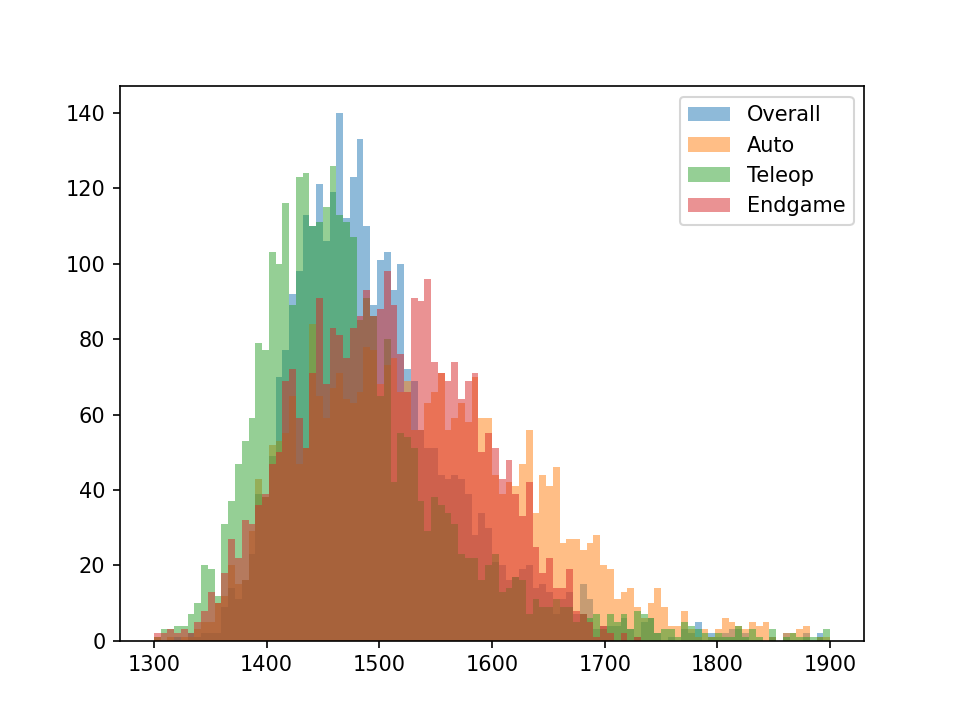

2017
[1900.85, 1850.1, 1847.68, 1827.57, 1806.14, 1804.87, 1799.24, 1797.48, 1795.21, 1791.54]
[1841.54, 1826.91, 1795.75, 1775.38, 1758.98, 1755.68, 1746.01, 1745.31, 1744.39, 1742.14]



<IPython.core.display.Javascript object>


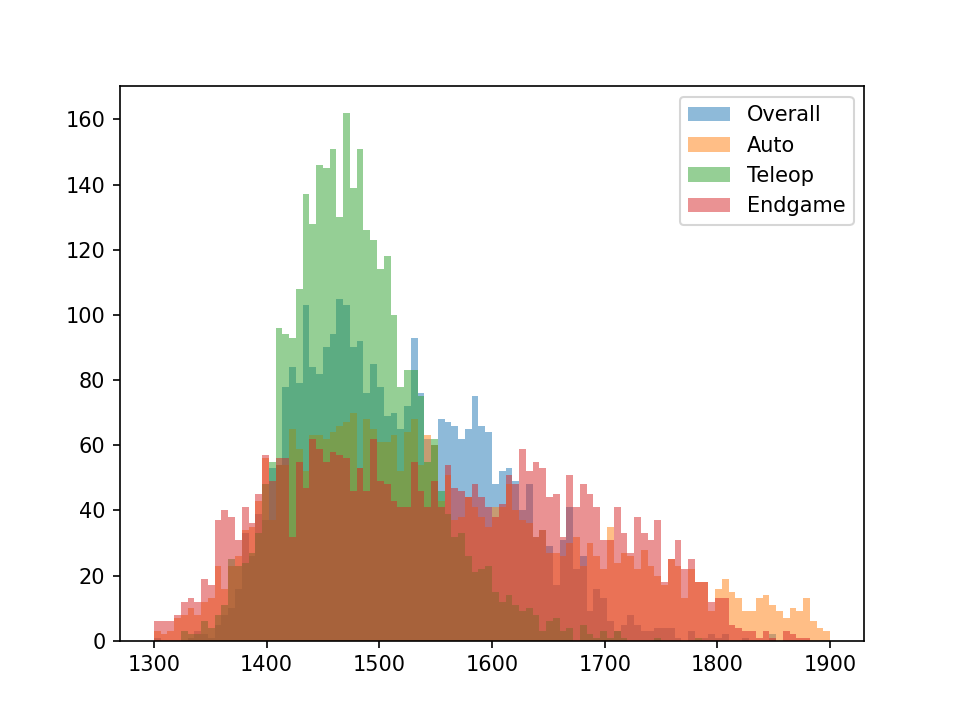

2018
[1986.36, 1977.69, 1936.21, 1924.55, 1903.92, 1898.27, 1897.83, 1896.08, 1892.49, 1891.18]
[1996.87, 1982.13, 1962.01, 1921.73, 1916.26, 1902.85, 1897.79, 1895.58, 1890.24, 1886.91]



<IPython.core.display.Javascript object>


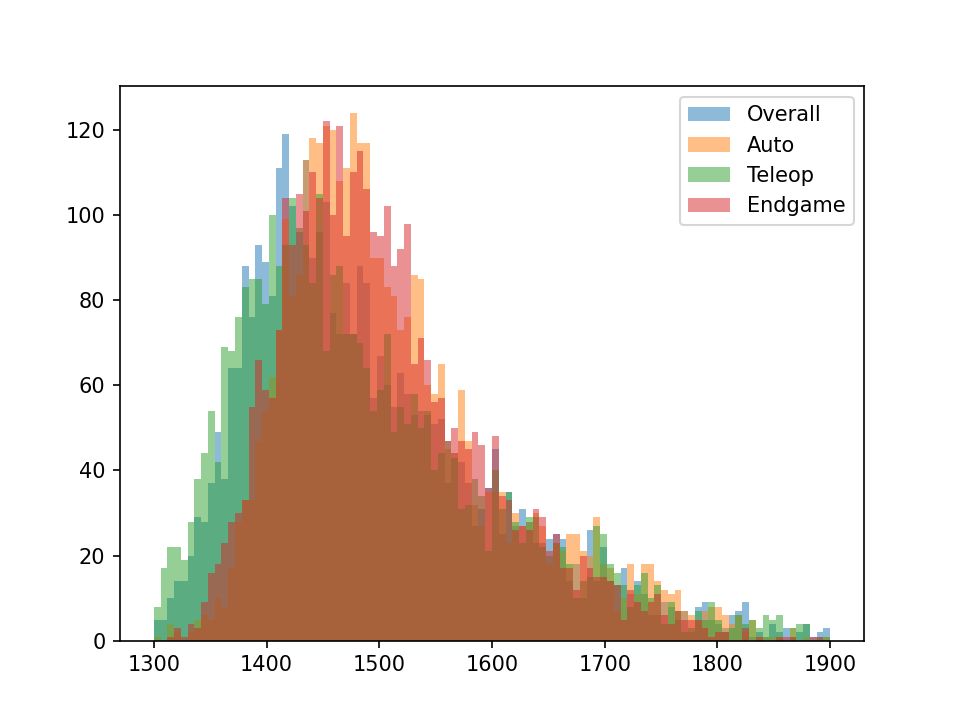

2019
[1866.3, 1861.5, 1857.31, 1839.07, 1835.65, 1826.47, 1825.36, 1819.33, 1806.29, 1802.3]
[1863.33, 1851.16, 1847.64, 1835.39, 1828.07, 1821.66, 1801.54, 1795.74, 1781.27, 1780.14]



<IPython.core.display.Javascript object>


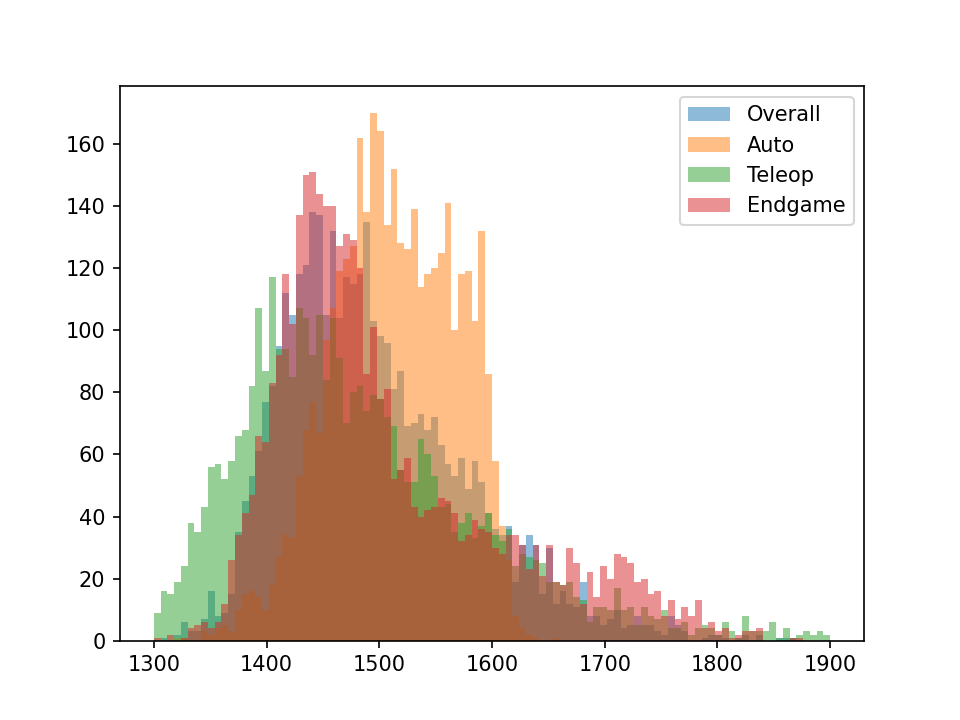

2020
[1869.68, 1855.21, 1828.49, 1809.62, 1801.55, 1794.94, 1791.48, 1788.08, 1787.46, 1786.77]
[1882.08, 1850.6, 1837.48, 1814.15, 1802.62, 1794.85, 1793.01, 1789.1, 1780.41, 1772.05]



<IPython.core.display.Javascript object>


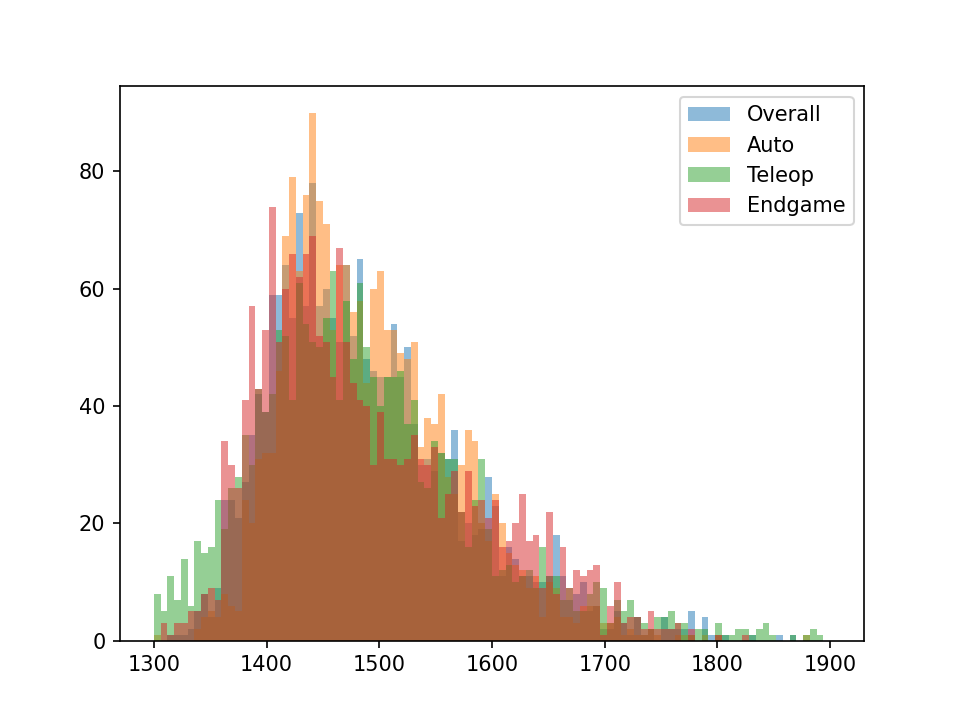

In [11]:
for year in range(2016, 2021):
    new_data = list(sorted([x[-1] for x in all_elos[year].values()])[::-1])
    auto_data = list(sorted([x[-1] for x in auto_elos[year].values()])[::-1])
    teleop_data = list(sorted([x[-1] for x in teleop_elos[year].values()])[::-1])
    endgame_data = list(sorted([x[-1] for x in endgame_elos[year].values()])[::-1])
    old_data = list(sorted([x[-1] for x in elos[year].values()])[::-1])

    print(year)
    print(new_data[:10])
    print(old_data[:10])
    print()
    
    fig, ax = plt.subplots()
    ax.hist(new_data, bins=100, alpha=0.5, range=(1300, 1900), label="Overall")
    ax.hist(auto_data, bins=100, alpha=0.5, range=(1300, 1900), label="Auto")
    ax.hist(teleop_data, bins=100, alpha=0.5, range=(1300, 1900), label="Teleop")
    ax.hist(endgame_data, bins=100, alpha=0.5, range=(1300, 1900), label="Endgame")
    # ax.hist(old_data, bins=50, alpha=0.25)
    ax.legend()
    fig.show()